# **Importing Data & Dependencies**

In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.io as pio
import seaborn as sns
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import joblib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

users_df = pd.read_csv("/content/drive/My Drive/Users.csv")
ratings_df = pd.read_csv("/content/drive/My Drive/Ratings.csv")
books_df = pd.read_csv("/content/drive/My Drive/Books.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [ ]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [ ]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


# **Preprocessing Data**

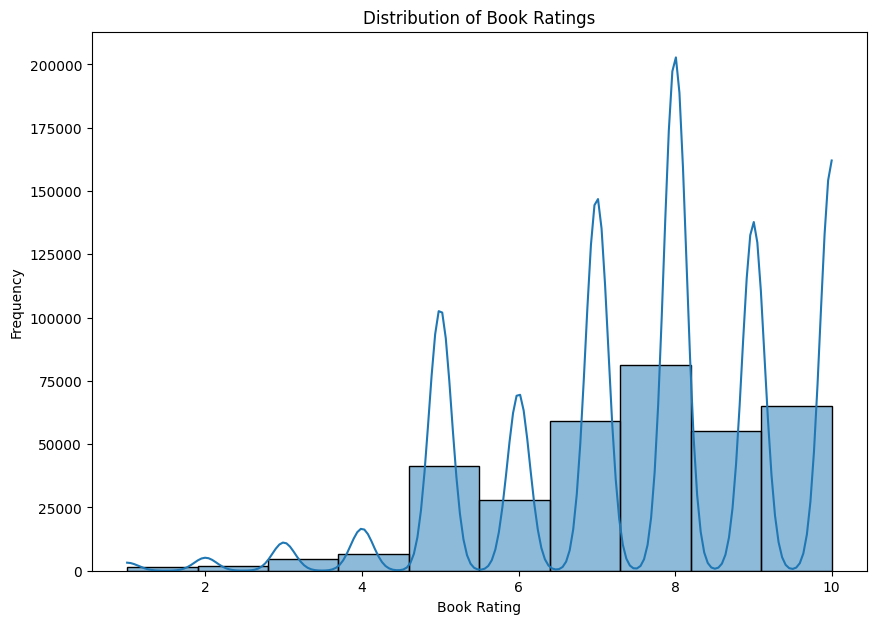

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(df_selected['Book-Rating'], bins=10, kde=True)
plt.title('Distribution of Book Ratings')
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.show()

Summary Statistics of Number of Ratings per User:
count    28868.000000
mean        11.937751
std         63.569295
min          2.000000
25%          2.000000
50%          4.000000
75%          9.000000
max       6943.000000
Name: Book-Rating, dtype: float64


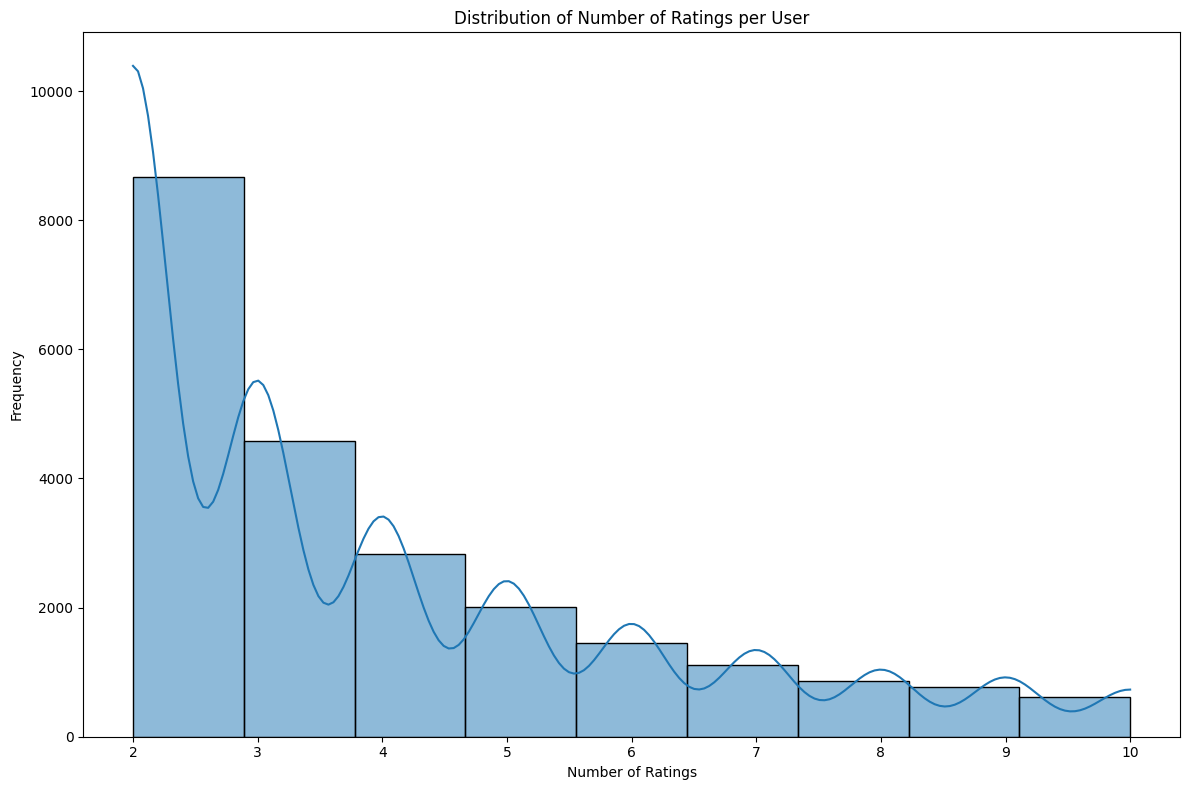

In [28]:
# Calculate number of ratings per user
ratings_per_user = df_selected.groupby('User-ID')['Book-Rating'].count()
# Optionally, print summary statistics
print("Summary Statistics of Number of Ratings per User:")
print(ratings_per_user.describe())


# Filter out extreme outliers (e.g., users with more than 100 ratings)
ratings_per_user = ratings_per_user[ratings_per_user <= 10]

# Plot histogram with adjusted bins and KDE
plt.figure(figsize=(12, 8))
sns.histplot(ratings_per_user, bins=9, kde=True)
plt.title('Distribution of Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Summary Statistics of Number of Ratings per User:
count    128186.000000
mean          2.688429
std           8.055110
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         556.000000
Name: Book-Rating, dtype: float64


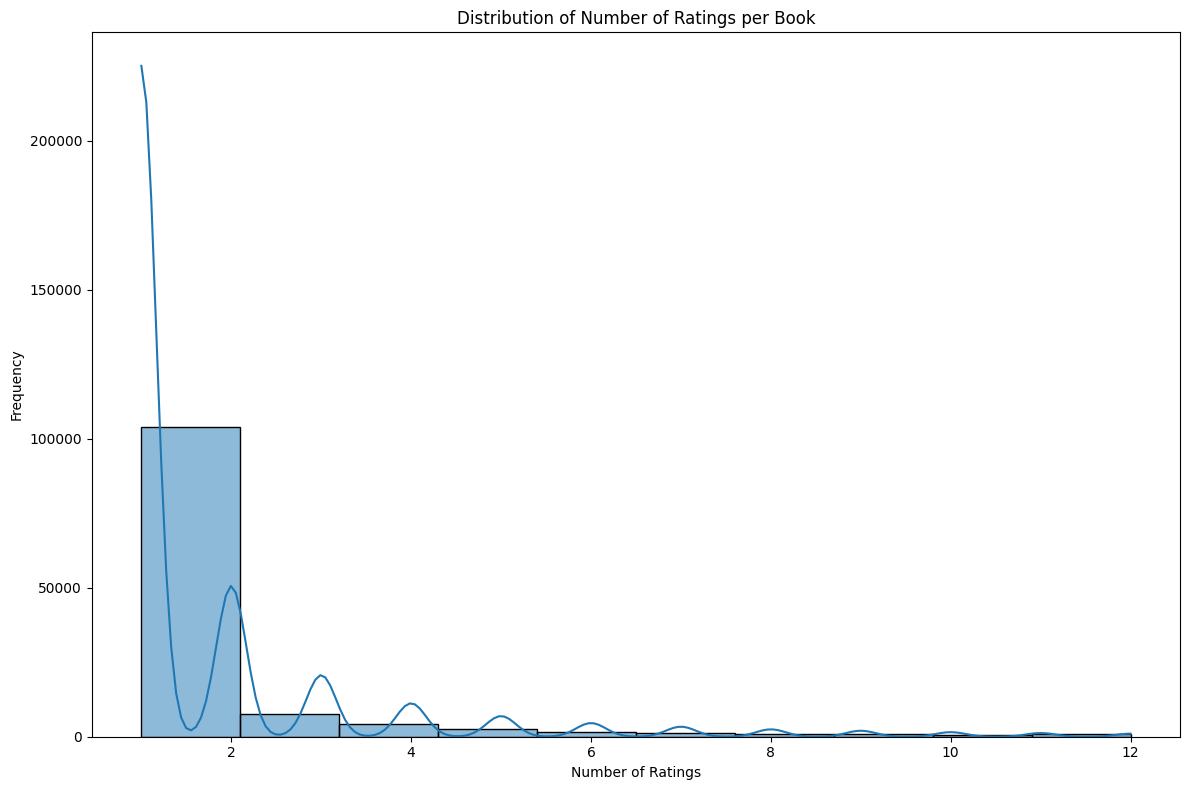

In [ ]:

# Calculate number of ratings per book
ratings_per_book = df_selected.groupby('Book-Title')['Book-Rating'].count()
# Optionally, print summary statistics
print("Summary Statistics of Number of Ratings per User:")
print(ratings_per_book.describe())

# Filter out extreme outliers if necessary
ratings_per_book = ratings_per_book[ratings_per_book <= 12]  # Example: filter books with more than 100 ratings

# Plot histogram with adjusted bins and KDE
plt.figure(figsize=(12, 8))
sns.histplot(ratings_per_book, bins=10, kde=True)
plt.title('Distribution of Number of Ratings per Book')
plt.xlabel('Number of Ratings')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

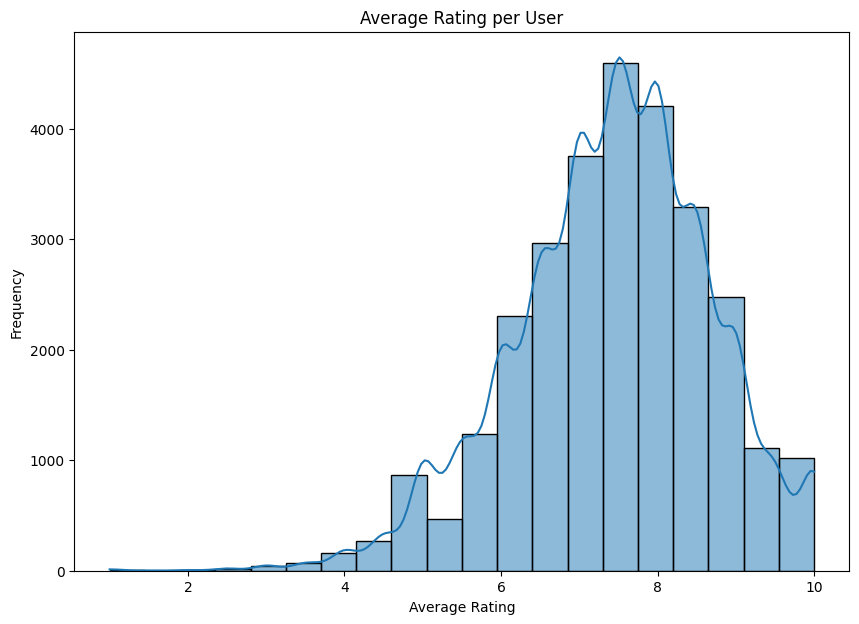

In [ ]:
#Bias and Fairness Analysis: Analyze if the model shows any bias towards specific users or books.
user_avg_rating = df_selected.groupby('User-ID')['Book-Rating'].mean()
book_avg_rating = df_selected.groupby('Book-Title')['Book-Rating'].mean()

plt.figure(figsize=(10, 7))
sns.histplot(user_avg_rating, bins=20, kde=True)
plt.title('Average Rating per User')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

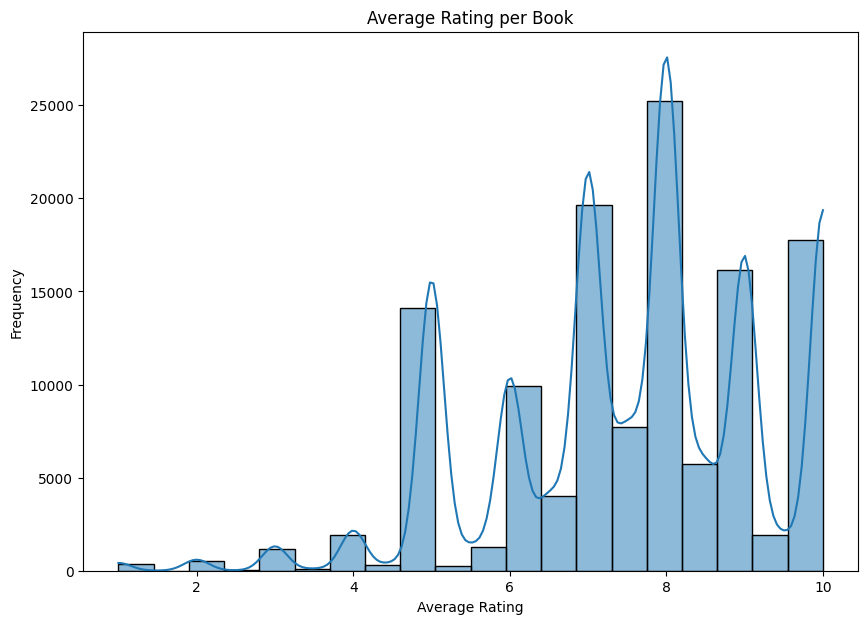

In [ ]:
plt.figure(figsize=(10, 7))
sns.histplot(book_avg_rating, bins=20, kde=True)
plt.title('Average Rating per Book')
plt.xlabel('Average Rating')
plt.ylabel('Frequency')
plt.show()

# **The Tensorflow Model**

Epoch 1/50
4308/4308 [==============================] - 291s 67ms/step - loss: 12.9532 - mean_squared_error: 11.6603 - val_loss: 3.7746 - val_mean_squared_error: 2.9859
Epoch 2/50
4308/4308 [==============================] - 273s 63ms/step - loss: 4.2309 - mean_squared_error: 3.8390 - val_loss: 2.7952 - val_mean_squared_error: 2.6646
Epoch 3/50
4308/4308 [==============================] - 275s 64ms/step - loss: 3.0564 - mean_squared_error: 2.9910 - val_loss: 2.7191 - val_mean_squared_error: 2.6797
Epoch 4/50
4308/4308 [==============================] - 272s 63ms/step - loss: 2.5380 - mean_squared_error: 2.4970 - val_loss: 2.7820 - val_mean_squared_error: 2.7408
Epoch 5/50
4308/4308 [==============================] - 276s 64ms/step - loss: 2.1786 - mean_squared_error: 2.1356 - val_loss: 2.8273 - val_mean_squared_error: 2.7836
Epoch 6/50
2154/2154 [==============================] - 5s 2ms/step - loss: 2.7190 - mean_squared_error: 2.6797
Mean Squared Error: 2.67969012260437


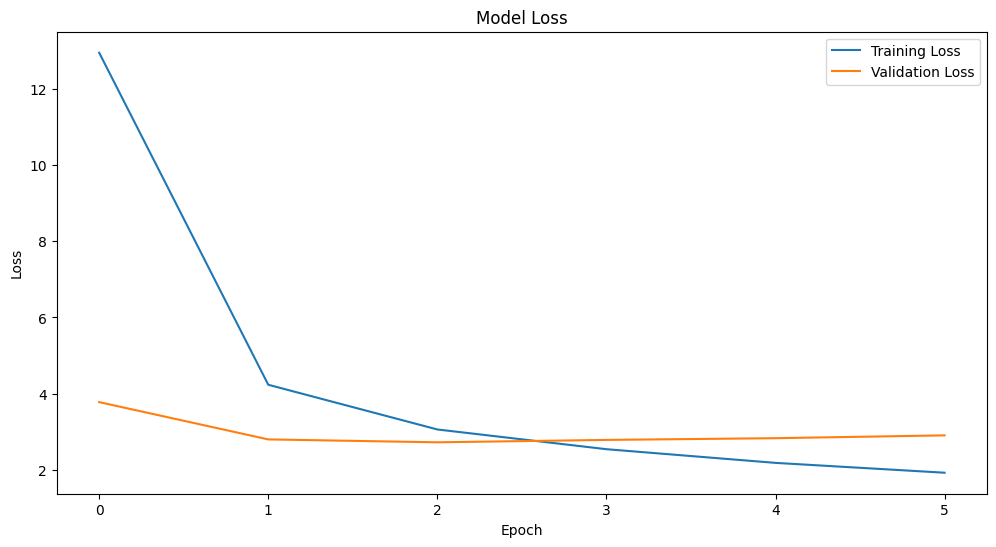

In [12]:
# Merge datasets
merged_df = pd.merge(ratings_df, books_df, on='ISBN')
final_df = pd.merge(merged_df, users_df, on='User-ID')

# Select the features that we need
df_selected = final_df[["User-ID", "Book-Rating", "Book-Title", "Book-Author"]]

# Drop NA values
df_selected = df_selected[df_selected['Book-Rating'] != 0]

# Convert specific columns to integers and strings
df_selected['User-ID'] = df_selected['User-ID'].astype(int)
df_selected['Book-Rating'] = df_selected['Book-Rating'].astype(int)
df_selected['Book-Title'] = df_selected['Book-Title'].astype(str)
df_selected['Book-Author'] = df_selected['Book-Author'].astype(str)

# Count number of ratings per user
user_ratings_count = df_selected.groupby('User-ID')['Book-Rating'].count()

# Filter users with more than one rating
active_users = user_ratings_count[user_ratings_count > 1].index

# Filter the dataset to keep only active users
df_selected = df_selected[df_selected['User-ID'].isin(active_users)]

# Split data into train and test sets
X = df_selected.drop(['Book-Rating'], axis=1)
y = df_selected['Book-Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define categorical and numerical columns
categorical_cols = ['Book-Title', 'Book-Author']
numerical_cols = ['User-ID']

# Preprocessor for categorical and numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough'
)

# Fit and transform preprocessing on training data, and transform on test data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Save the fitted preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

# Apply VarianceThreshold to reduce dimensionality
selector = VarianceThreshold(threshold=0.1)
X_train_selected = selector.fit_transform(X_train_preprocessed)
X_test_selected = selector.transform(X_test_preprocessed)

# Convert sparse matrix to dense array
X_train_selected = X_train_selected.toarray()
X_test_selected = X_test_selected.toarray()

# Mapping user and book IDs
user_id_mapping = {id: idx for idx, id in enumerate(df_selected['User-ID'].unique())}
book_id_mapping = {title: idx for idx, title in enumerate(df_selected['Book-Title'].unique())}

df_selected['user_idx'] = df_selected['User-ID'].map(user_id_mapping)
df_selected['book_idx'] = df_selected['Book-Title'].map(book_id_mapping)

# Split mapped data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_selected[['user_idx', 'book_idx']], df_selected['Book-Rating'], test_size=0.2, random_state=42)

# Define the model architecture with dropout and batch normalization layers
user_input = Input(shape=(1,), name='user_input')
user_embedding = Embedding(input_dim=len(user_id_mapping), output_dim=32, name='user_embedding')(user_input)
user_vec = Flatten(name='user_flatten')(user_embedding)

book_input = Input(shape=(1,), name='book_input')
book_embedding = Embedding(input_dim=len(book_id_mapping), output_dim=32, name='book_embedding')(book_input)
book_vec = Flatten(name='book_flatten')(book_embedding)

additional_features_input = Input(shape=(X_train_selected.shape[1],), name='additional_features_input')

concat = Concatenate()([user_vec, book_vec, additional_features_input])
dense1 = Dense(128, activation='relu', kernel_regularizer='l2')(concat)
batch_norm1 = BatchNormalization()(dense1)
dropout1 = Dropout(0.6)(batch_norm1)
dense2 = Dense(64, activation='relu', kernel_regularizer='l2')(dropout1)
batch_norm2 = BatchNormalization()(dense2)
dropout2 = Dropout(0.6)(batch_norm2)
output = Dense(1, activation='linear')(dropout2)

# Compile the model
model = Model(inputs=[user_input, book_input, additional_features_input], outputs=output)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005), metrics=['mean_squared_error'])

# Define early stopping criteria
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

# Prepare inputs for training
user_ids_train = X_train['user_idx'].values
book_ids_train = X_train['book_idx'].values
user_ids_test = X_test['user_idx'].values
book_ids_test = X_test['book_idx'].values

# Train the model
history = model.fit(
    [user_ids_train, book_ids_train, X_train_selected], y_train,
    validation_data=([user_ids_test, book_ids_test, X_test_selected], y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate([user_ids_test, book_ids_test, X_test_selected], y_test)
print("Mean Squared Error:", mse)

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Evaluating The Model & Personalized Recommendation**


In [ ]:
# Baseline: Predicting the average rating for all books
average_rating = df_selected['Book-Rating'].mean()
df_selected['AverageRating'] = average_rating

# Calculate MAE and MSE for the baseline
mae_baseline = mean_absolute_error(df_selected['Book-Rating'], df_selected['AverageRating'])
mse_baseline = mean_squared_error(df_selected['Book-Rating'], df_selected['AverageRating'])

# Calculate MAE and MSE for the model
mae_model = mean_absolute_error(recommendations['Actual Rating'], recommendations['Predicted Rating'])
mse_model = mean_squared_error(recommendations['Actual Rating'], recommendations['Predicted Rating'])

# Print the results
print(f"Baseline Mean Absolute Error (MAE): {mae_baseline:.2f}")
print(f"Baseline Mean Squared Error (MSE): {mse_baseline:.2f}")
print(f"Model Mean Absolute Error (MAE): {mae_model:.2f}")
print(f"Model Mean Squared Error (MSE): {mse_model:.2f}")

# Calculate % correctness (improvement over baseline)
mae_improvement = (mae_baseline - mae_model) / mae_baseline * 100
mse_improvement = (mse_baseline - mse_model) / mse_baseline * 100

print(f"Model improvement over baseline (MAE): {mae_improvement:.2f}%")
print(f"Model improvement over baseline (MSE): {mse_improvement:.2f}%")

Baseline Mean Absolute Error (MAE): 1.50
Baseline Mean Squared Error (MSE): 3.39
Model Mean Absolute Error (MAE): 0.85
Model Mean Squared Error (MSE): 1.36
Model improvement over baseline (MAE): 43.21%
Model improvement over baseline (MSE): 59.87%


In [51]:
# Display recommendations
recommendations = pd.DataFrame({
    'User-ID': user_ids_test,
    'Book-ID': book_ids_test,
    'Actual Rating': y_test,
    'Predicted Rating': predicted_ratings
})

# Print sample personalized recommendations
print("\nSample Personalized Recommendations:")
print(tabulate(recommendations.head(10), headers='keys', tablefmt='psql'))


Sample Personalized Recommendations:
+----+-----------+-----------+-----------------+--------------------+
|    |   User-ID |   Book-ID |   Actual Rating |   Predicted Rating |
|----+-----------+-----------+-----------------+--------------------|
|  0 |    761268 |      9590 |               5 |            5.22664 |
|  1 |    513617 |      2826 |               8 |            8.54076 |
|  2 |    435668 |      1858 |               9 |            7.68707 |
|  3 |     93595 |       256 |               8 |            8.09329 |
|  4 |    765679 |      9065 |               8 |            6.62704 |
|  5 |    399132 |      1553 |               5 |            7.0655  |
|  6 |    694340 |      6454 |               9 |            7.62524 |
|  7 |    808887 |     11239 |              10 |            7.59035 |
|  8 |    699404 |      6587 |               5 |            6.08537 |
|  9 |    492386 |      2506 |               8 |            8.46229 |
+----+-----------+-----------+-----------------+----

In [49]:
# Sample data
data = {
'User-ID': [37114 , 513617, 435668, 93595, 765679, 399132, 694340, 808887, 699404, 492386],
'Book-ID': [780, 2826, 1858, 256, 9065, 1553, 6454, 11239, 6587, 2506],
'Actual Rating':[5, 8, 9, 8, 8, 5, 9, 10, 5, 8],
'Predicted Rating': [5.22664, 8.54076, 7.68707, 8.09329, 6.62704, 7.0655, 7.62524, 7.59035, 6.08537, 8.46229]
}

recommendations = pd.DataFrame(data)

# Create traces for actual and predicted ratings
trace_actual = go.Scatter(x=recommendations.index,
                          y=recommendations['Actual Rating'],
                          mode='lines+markers',
                          name='Actual Rating')

trace_predicted = go.Scatter(x=recommendations.index,
                             y=recommendations['Predicted Rating'],
                             mode='lines+markers',
                             name='Predicted Rating')

# Create layout with adjusted parameters
layout = go.Layout(
    title='Actual vs Predicted Ratings',
    xaxis=dict(title='Recommendation Index', showgrid=True, zeroline=False),
    yaxis=dict(title='Rating', showgrid=True, zeroline=False),
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    margin=dict(l=50, r=50, t=50, b=50),
    height=400,
    width=800
)

# Combine traces into a data list
data = [trace_actual, trace_predicted]

# Create figure and display using Plotly
fig = go.Figure(data=data, layout=layout)
pio.show(fig)

2154/2154 [==============================] - 6s 3ms/step


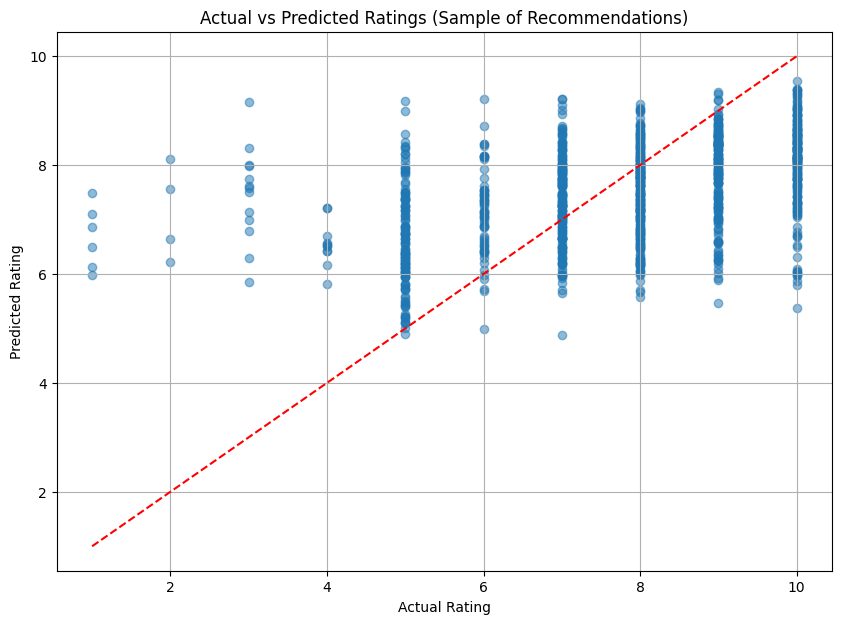

In [39]:
predictions_df = pd.DataFrame({
    'User-ID': user_ids_test,
    'Book-ID': book_ids_test,
    'Actual Rating': y_test,
    'Predicted Rating': predicted_ratings
})
# Sample a subset of recommendations
num_samples = 1000
random_indices = np.random.choice(len(predictions_df), num_samples, replace=False)
sample_recommendations = predictions_df.iloc[random_indices]

# Plotting the actual vs predicted ratings
plt.figure(figsize=(10, 7))
plt.scatter(sample_recommendations['Actual Rating'], sample_recommendations['Predicted Rating'], alpha=0.5)
plt.plot([min(sample_recommendations['Actual Rating']), max(sample_recommendations['Actual Rating'])],
         [min(sample_recommendations['Actual Rating']), max(sample_recommendations['Actual Rating'])],
         color='red', linestyle='--')
plt.title('Actual vs Predicted Ratings (Sample of Recommendations)')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.grid(True)
plt.show()

# **Saving the Model**

In [ ]:
# Save the model
model.save('tf_model.h5')